# Práctica 3: Modelo cinemático inverso de un  y planteamiento de trayectoria

## Objetivo

El objetivo de esta práctica es que el alumno comprenda, interprete y modifique la información básica de los formatos de Universal Robot Description File (URDF).


### Metas 

- Que el alumno aplique un modelo cinemático inverso para calcular una trayectoria a partir de una posición actual hacia una posición final
- Que el alumno grafique y analice los resultados del modelo
- Que el alumno configure un repositorio en línea e incluya en éste su práctica

### Contribución al perfil del egresado

La siguiente práctica contribuye en los siguientes puntos al perfil del egresado:

#### Aptitudes y habilidades

- Para modelar, simular e interpretar el comportamiento de los sistemas mecatrónicos.
- Para diseñar, construir, operar y mantener los sistemas mecatrónicos y sus componentes.

#### Actitudes

- Tener confianza en su preparación académica.
- Comprometido con su actualización, superación y competencia profesional.

#### De tipo social

- Promover el cambio en la mentalidad frente a la competitividad internacional.

## Rúbrica de evaluación

La evaluación de la práctica contará de los siguientes puntos y se evaluará con los siguientes criterios:

| Elemento | Porcentaje |
| ------:| ----------- |
| **Cuestionario previo** | 15% | 
| **Desarrollo** | 35% |
| **Análisis de resultados**  | 35% |
| **Conclusiones** | 15% |

| Elemento | Malo | Regular | Bueno |
| ------:| ------ | --------| ------|
| **Cuestionario previo** | El trabajo no contiene cuestionario previo o todas las preguntas son incorrectas (0%)| Al menos la mitad de las preguntas son correctas (8%) |  Todas las preguntas son correctas (15%) |
| **Desarrollo** | El trabajo no contiene desarrollo o su planteamiento no concuerda con lo deseado (0%) | El desarrollo está mal planteado o no llega a los resultados esperados (10%) | El desarrollo tiene un planteamiento adecuado y llega a los resultados esperados (35%) |
| **Análisis de resultados**  | El trabajo no contiene análisis de resultados o la información no se está interpretando correctamente (0%) | La interpretación de los resultados es parcial o desorganizada (10%) | Realiza un correcto análisis de los resultados de forma organizada   (35%) |
| **Conclusiones** | El trabajo no contiene conclusiones o no hacen referencia al trabajo desarrollado y los objetivos planteados (0%) | La redacción de las conclusiones es desorganizada o confusa (8%) | Las conclusiones del trabajo son claras y hacen referencia al trabajo desarrollado y los objetivos planteados (15%) | 



## Introducción

### Transformaciones homogéneas
Las transformaciones homogéneas permiten hacer el planteamiento del modelo cinemático de un robot, considerando las posiciones y orientaciones de las juntas del robot respecto al sistema de referencia de una junta anterior

Este planteamiento es el **modelo de cinemática directa**, que nos permite obtener la posición y velocidad del efector final de un manipulador en términos de los valores de la posición y velocidad de sus juntas (espacio de trabajo)

A través de este modelo se puede obtener el **modelo de cinemática inversa**, que permite obtener la velocidad de las juntas de un robot a partir de la velocidad deseada del efector final.

### Planteamiento de una trayectoria
Si se conoce el punto inicial y final de una trayectoria deseada, se pueden obtener los puntos intermedios de la trayectoria. La forma más fácil de realizar esta interpolación es a través de un spline. El orden del spline permitirá controlar las condiciones inicial y final de la posición, velocidad ó aceleración que tendrá el efector final durante el trayecto. 

Juntando la interpolación de la trayectoria y el modelo de la cinemática inversa, se pueden obtener todos los puntos intermedios de la trayectoria que deben seguir las juntas del robot para que el efector final siga una trayectoria.

## Cuestionario previo

Responder de forma breve las siguientes preguntas:

- ¿Qué es el análisis de dinámica inversa y qué nos permite obtener?
> Es una técnica utilizada en el campo de la robótica, biomecánica y la simulación de sistemas mecánicos. En este análisis, se parte de las posiciones, velocidades y aceleraciones deseadas de los componentes de un sistema para calcular las fuerzas y momentos necesarios en sus actuadores o puntos de apoyo. A diferencia de la dinámica directa (o directa), donde se calculan los movimientos a partir de las fuerzas aplicadas, la dinámica inversa nos permite entender qué esfuerzos se necesitan para lograr un movimiento específico.

  > El análisis de dinámica inversa nos permite obtener:
  >   * Fuerzas y Torques: en los actuadores o puntos de unión del sistema.
  >   * Esfuerzos en cada componente del sistema mecánico: lo cual es útil para verificar si los materiales pueden soportar las cargas.
  >   * Datos de esfuerzo acumulado o carga de trabajo: a lo largo de un ciclo de movimiento, ayudando en el análisis de desgaste o vida útil    del sistema.

- ¿A través de qué modelados se puede realizar un análisis de dinámica inversa?
>    * Modelo basado en la dinámica de Newton-Euler: Utiliza las leyes de Newton y Euler para calcular las fuerzas y torques en cada eslabón del sistema mecánico. Se aplica generalmente en manipuladores robóticos, donde se divide el sistema en eslabones y se modela cada uno de ellos de forma recursiva.
Este enfoque es eficiente computacionalmente y se emplea comúnmente en robótica y sistemas de control.

>    * Modelo basado en Lagrange-Euler: Utiliza las ecuaciones de Lagrange para describir la dinámica del sistema a través de la energía cinética y potencial. Este método es particularmente útil cuando el sistema tiene un número de grados de libertad elevado y cuando se desea obtener ecuaciones en una forma compacta.
Es muy utilizado en la biomecánica, robótica, y sistemas de múltiples cuerpos.

>    *  Modelo de trabajo virtual o método de las fuerzas generalizadas: Se basa en el principio del trabajo virtual, donde se evalúa el trabajo realizado por fuerzas y torques virtuales para obtener las ecuaciones dinámicas. Este enfoque es útil en sistemas mecánicos complejos, como los robots paralelos y los sistemas de múltiples cuerpos, donde se necesita alta precisión.
>     Permite simplificar los cálculos al evitar ecuaciones redundantes.

>    * Modelado computacional con software de simulación: Se pueden utilizar herramientas de simulación como MATLAB, Simulink, ADAMS o software especializado en dinámica, como OpenSim o MSC Adams.
>  Estos programas permiten construir modelos complejos sin necesidad de resolver manualmente las ecuaciones dinámicas, ya que utilizan una combinación de métodos de Newton-Euler y Lagrange-Euler. Son especialmente útiles para simulaciones y prototipos de sistemas complejos en ingeniería y biomecánica.

>    * Modelo de cuerpos rígidos y cadenas cinemáticas: Modela cada componente del sistema como un cuerpo rígido y usa las relaciones de movimiento entre los cuerpos mediante cadenas cinemáticas.
>         Es útil para estructuras robóticas en serie o cadenas cinemáticas abiertas, donde se busca determinar el comportamiento de cada cuerpo dentro de un sistema articulado. Este enfoque se emplea también en biomecánica y simulación de movimientos humanos.

- ¿De qué condiciones ó fenómenos físicos dependen los pares en las juntas de un robot para seguir una trayectoria?

>    * Dinámica del Robot
>      + La masa y distribución de masas de los eslabones afectan directamente el par necesario, ya que  influencian la inercia de cada componente. A mayor inercia, se requiere un par más elevado para cambiar de estado de movimiento.
>      + La aceleración requerida en cada junta también afecta el par, ya que según la segunda ley de Newton, una mayor aceleración requiere una mayor fuerza (o par).
>      + La fricción en las articulaciones y mecanismos es un factor importante. Los pares deben compensar la fricción en los engranajes, cojinetes y otras partes móviles del sistema.
    
>    *  Gravedad
>      + La fuerza gravitacional actúa sobre cada eslabón del robot, generando una carga adicional en los actuadores que debe compensarse para mantener el robot en su posición o movimiento deseado.
>      + La contribución de la gravedad depende de la orientación de los eslabones en cada instante. En configuraciones donde los eslabones están orientados en contra de la gravedad, el par requerido aumenta significativamente.

>    *  Cinemática de la Trayectoria
     + La posición, velocidad y aceleración deseada en cada instante a lo largo de la trayectoria determina el par necesario. A velocidades altas y con cambios de dirección bruscos, el par requerido aumenta debido a la aceleración y las fuerzas centrífugas.
      + La suavidad de la trayectoria también es crucial; trayectorias más abruptas o discontinuas exigen pares más elevados debido a los cambios súbitos en la velocidad y aceleración.

>    *  Interacciones con el Entorno
Si el robot debe interactuar con objetos o superficies externas, debe generarse un par adicional para vencer la resistencia externa o para realizar tareas como levantar, empujar o mover objetos.
En aplicaciones de contacto, como en el caso de robots de ensamblaje o soldadura, los pares deben compensar las fuerzas de contacto con el entorno para cumplir con la tarea sin desviarse de la trayectoria.

>    *  Control de Feedback (retroalimentación)
     + Los sistemas de control ajustan el par en tiempo real para corregir errores en la trayectoria, respondiendo a variaciones imprevistas o perturbaciones externas.
    
>      + Los sistemas de control en lazo cerrado requieren que el par se ajuste continuamente en función del error de posición y velocidad, por lo que la precisión de sensores y actuadores también influye en el cálculo de los pares.

>    *  Rigidez y Flexibilidad del Sistema
>      + En robots con eslabones flexibles o estructuras no perfectamente rígidas, pueden aparecer fenómenos como la vibración o el desfase en la respuesta de las juntas. Esto puede requerir pares adicionales para compensar estas oscilaciones.
>      + La elasticidad de los actuadores y las partes de transmisión también pueden generar comportamientos no deseados, requiriendo pares adicionales para estabilizar el movimiento.
    
>    *  Resonancia y Vibraciones
La resonancia es un fenómeno que puede amplificar las vibraciones en ciertos puntos de la trayectoria, especialmente en velocidades o posiciones específicas. Esto puede exigir pares adicionales para contrarrestar la resonancia y estabilizar la trayectoria.

- ¿Cómo se aplica la derivada total de una función que está en términos de otras variables que a su vez están en términos de la variable respecto a la que se realzia la derivada total?
>     Se calcula aplicando la regla de la cadena para tener en cuenta todas las vías en las que la variable independiente afecta la función.

En caso de integrar imagenes, colocarlas en la carpeta *"imagenes"*

## Desarrollo

### 1. Planteamiento de la cinemática inversa y obtención de la trayectoria
En esta primera parte, se realiza el análisis de la cinemática inversa, que permite obtener las posiciones, velocidades y aceleraciones de las juntas del robot, dada **una posición inicial de las juntas y una posición final del efector final**. Se puede retomar de la práctica anterior. 
Un diagrama del robot se muestra en la imagen:

<img src="imagenes/P3_IM1.png" alt = "Robot RRR" width="300" height="300" display= "block"/>



In [2]:
from sympy import solve, Symbol, Matrix, cos, sin, simplify, pi, diff, symbols
import matplotlib
import matplotlib.pyplot as plt
import numpy

dim = (0.3, 0.3, 0.3)
base_dim = (0, 0, 0.1)
base_rot = (pi/2, 0, 0)
mass = (10, 10, 10)
#Parámetros de dimensiones
dim = dim
base_dim = base_dim
base_rot = base_rot
#Variables para cinemática directa
theta_O_1 = Symbol('theta_O_1')
theta_1_2 = Symbol('theta_1_2')
theta_2_3 = Symbol('theta_2_3')
#Grados de libertad
x_O_P = Symbol('x_O_P')
z_O_P = Symbol('y_O_P')
theta_O_P = Symbol('theta_O_P')
#Velocidades
x_O_P_dot = Symbol('x_O_P_dot')
z_O_P_dot = Symbol('y_O_P_dot')
theta_O_P_dot = Symbol('theta_O_P_dot')
def trans_homo(x, y, z, roll, pitch, yaw):
    # Matriz de rotación combinada
    R = Matrix([
        [cos(yaw)*cos(pitch), cos(yaw)*sin(pitch)*sin(roll) - sin(yaw)*cos(roll), cos(yaw)*sin(pitch)*cos(roll) + sin(yaw)*sin(roll)],
        [sin(yaw)*cos(pitch), sin(yaw)*sin(pitch)*sin(roll) + cos(yaw)*cos(roll), sin(yaw)*sin(pitch)*cos(roll) - cos(yaw)*sin(roll)],
        [-sin(pitch),         cos(pitch)*sin(roll),                            cos(pitch)*cos(roll)]
    ])
    
    # Matriz de transformación homogénea
    T = Matrix([
        [R[0,0], R[0,1], R[0,2], x],
        [R[1,0], R[1,1], R[1,2], y],
        [R[2,0], R[2,1], R[2,2], z],
        [0,      0,      0,      1]
    ])
    return T
#Transformaciones homogéneas
T_O_O = trans_homo(base_dim[0], base_dim[1], base_dim[2], base_rot[0], base_rot[1], base_rot[2])
T_O_1 = trans_homo(0, 0, 0, 0, 0, theta_O_1)
T_1_2 = trans_homo(dim[0], 0, 0, 0, 0, theta_1_2)
T_2_3 = trans_homo(dim[1], 0, 0, 0, 0, theta_2_3)
T_3_P = trans_homo(dim[2], 0, 0, 0, 0, 0)
T_O_1 = simplify(T_O_O * T_O_1)
T_O_2 = simplify(T_O_1 * T_1_2)
T_O_3 = simplify(T_O_2 * T_2_3)
T_O_P = simplify(T_O_3 * T_3_P)
T_O_P = simplify(T_O_P)
xi_O_P = Matrix([T_O_P[0, 3], T_O_P[2, 3], theta_O_1 + theta_1_2 + theta_2_3])
#jacobiano
J = Matrix.hstack(diff(xi_O_P, theta_O_1), 
                  diff(xi_O_P, theta_1_2), 
                  diff(xi_O_P, theta_2_3))
#jacobiano inverso
J_inv = J.inv()
#Transformaciones de centros de masa
T_1_C1 = trans_homo(dim[0] / 2, 0, 0, 0, 0, 0)
T_2_C2 = trans_homo(dim[1] / 2, 0, 0, 0, 0, 0)
T_3_C3 = trans_homo(dim[2] / 2, 0, 0, 0, 0, 0)
T_O_C1 = simplify(T_O_1 * T_1_C1)
T_O_C2 = simplify(T_O_2 * T_2_C2)
T_O_C3 = simplify(T_O_3 * T_3_C3)
#Vectores de posición de sistemas de referencia
p_0_1 = T_O_1[:3, 3]
p_1_2 = T_1_2[:3, 3]
p_2_3 = T_2_3[:3, 3]
p_0_1 = T_O_1[:3, 3]
p_0_2 = T_O_2[:3, 3]
p_0_3 = T_O_3[:3, 3]
#Vectores de posición de centros de masa
p_1_C1 = T_1_C1[:3, 3]
p_2_C2 = T_2_C2[:3, 3]
p_3_C3 = T_3_C3[:3, 3]
p_0_C1 = T_O_C1[:3, 3]
p_0_C2 = T_O_C2[:3, 3]
p_0_C3 = T_O_C3[:3, 3]
#Rotaciones
R_0_1 = T_O_1[:3, :3]
R_1_2 = T_1_2[:3, :3]
R_2_3 = T_2_3[:3, :3]
Id = Matrix([[1,0,0], [0,1,0], [0,0,1]]) 
#Masas
m1 = mass[0]
m2 = mass[1]
m3 = mass[2]
#Matrices de Inercia
Ic1 = Matrix([[(m1/12)*(0.03**2 + 0.03**2), 0, 0], 
                        [0, (m1/12)*(0.3**2 + 0.03**2), 0], 
                        [0, 0, (m1/12)*(0.3**2 + 0.03**2)]])
Ic2 = Matrix([[(m1/12)*(0.03**2 + 0.03**2), 0, 0], 
                        [0, (m1/12)*(0.3**2 + 0.03**2), 0], 
                        [0, 0, (m1/12)*(0.3**2 + 0.03**2)]])
Ic3 = Matrix([[(m1/12)*(0.03**2 + 0.03**2), 0, 0], 
                        [0, (m1/12)*(0.3**2 + 0.03**2), 0], 
                        [0, 0, (m1/12)*(0.3**2 + 0.03**2)]])
#Velocidades angulares
theta_O_1_dot = Symbol('theta_O_1_dot')
theta_1_2_dot = Symbol('theta_1_2_dot')
theta_2_3_dot = Symbol('theta_2_3_dot')
#Aceleraciones angulares
theta_O_1_dot_dot = Symbol('theta_O_1_dot_dot')
theta_1_2_dot_dot = Symbol('theta_1_2_dot_dot')
theta_2_3_dot_dot = Symbol('theta_2_3_dot_dot')
omega_1_1 = Matrix([0, 0, theta_O_1_dot])
omega_2_2 = Matrix([0, 0, theta_1_2_dot])
omega_3_3 = Matrix([0, 0, theta_2_3_dot])
#Gravedad
g = -9.81
def trans_homo(x, y, z, gamma, beta, alpha):
    T = Matrix([
        [cos(alpha)*cos(beta), -sin(alpha)*cos(gamma) + sin(beta)*sin(gamma)*cos(alpha), sin(alpha)*sin(gamma) + sin(beta)*cos(alpha)*cos(gamma), x],
        [sin(alpha)*cos(beta), sin(alpha)*sin(beta)*sin(gamma) + cos(alpha)*cos(gamma), sin(alpha)*sin(beta)*cos(gamma) - sin(gamma)*cos(alpha), y],
        [-sin(beta), sin(gamma)*cos(beta), cos(beta)*cos(gamma), z],
        [0, 0, 0, 1]
    ])
    return T
# Función para generar la trayectoria polinomial
def polinomial_trayectory_generator(
                                      frec = 5, 
                                      time = (0, 10), 
                                      q_in = (0.1, 0.1, 0.1), 
                                      gdl_fn = (0.4, 0.4, 1.57)
                                   ):
    global gdl, gdl_dot, gdl_dot_dot, lam_s, lam_s_dot, lam_s_dot_dot, samples, gdl_in, ws, ws_dot, ws_dot_dot, om_1_C1, om_2_C2, om_3_C3, vel_1_C1, vel_2_C2, vel_3_C3
    frec = frec
    a_0, a_1, a_2, a_3, a_4, a_5, t = symbols('a_0 a_1 a_2 a_3 a_4 a_5 t')
    lam = a_0 + a_1*t + a_2*(t**2) + a_3*(t**3) + a_4*(t**4) + a_5*(t**5)
    lam_dot = diff(lam, t)
    lam_dot_dot = diff(lam_dot, t)
    terms = solve([
      lam.subs(t, time[0]) - 0,
      lam.subs(t, time[1]) - 1,
      lam_dot.subs(t, time[0]) - 0,
      lam_dot.subs(t, time[1]) - 0,
      lam_dot_dot.subs(t, time[0]) - 0,
      lam_dot_dot.subs(t, time[1]) - 0
    ], [a_0, a_1, a_2, a_3, a_4, a_5], dict = True)
    #Lambda con valores sustituidos
    lam_s = lam.subs(terms[0])
    lam_s_dot = lam_dot.subs(terms[0])
    lam_s_dot_dot = lam_dot_dot.subs(terms[0])
    samples = frec * (time[1] - time[0]) + 1
    dt = 1.0 / frec
    #Posición inicial del efector final
    gdl_in = T_O_P[:3, 3].subs({theta_O_1: q_in[0],
                                theta_1_2: q_in[1],
                                theta_2_3: q_in[2]})
    #Creando arreglos para guardar las posiciones de los GDL
    gdl = []
    gdl_dot = []
    gdl_dot_dot = []
    for a in range(samples):
      gdl.append((gdl_in[0] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
                  gdl_in[1] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]), 
                  gdl_in[2] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2]) ))
      gdl_dot.append((lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
                      lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]), 
                      lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2]) ))
      gdl_dot_dot.append((lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
                      lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]), 
                      lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2]) ))
    #Obteniendo posición inicial del ws
    xi_desp = xi_O_P - Matrix([gdl_in[0], 
                               gdl_in[1], 
                               gdl_in[2]])
    #Calculando velocidad inicial
    xi_O_P_dot = Matrix([x_O_P_dot,
                         z_O_P_dot,
                         theta_O_P_dot])
    q_O_P_dot = J_inv * xi_O_P_dot #velocidad es jacobiano inverso por la velocidad inicial
    #Arreglos para guardar las posiciones del wsws = []
    ws_dot = []
    ws_dot_dot = []
    #Agregando posición inicial
    ws.append(q_in)
    #Agregando velocidad inicial
    q_dot_in = q_O_P_dot.subs({
      x_O_P_dot:     gdl_dot[0][0],
      z_O_P_dot:     gdl_dot[0][1],
      theta_O_P_dot: gdl_dot[0][2],
      theta_O_1: ws[0][0],
      theta_1_2: ws[0][1],
      theta_2_3: ws[0][2]})
    ws_dot.append(q_dot_in)
    #Calculando todos los valores por cinemática inversa
    for a in range(samples - 1):
      #Posición 
      ws.append((ws[a][0] + ws_dot[a][0] * dt,
                 ws[a][1] + ws_dot[a][1] * dt,
                 ws[a][2] + ws_dot[a][2] * dt))
      #Velocidad
      q_dot_iter = q_O_P_dot.subs({
                                      x_O_P_dot:gdl_dot[a+1][0],
                                      z_O_P_dot:gdl_dot[a+1][1],
                                      theta_O_P_dot: gdl_dot[a+1][2],
                                      theta_O_1: ws[a+1][0],
                                      theta_1_2: ws[a+1][1],
                                      theta_2_3: ws[a+1][2]})
      ws_dot.append(q_dot_iter)
      #Aceleración
      ws_dot_dot.append((
                    (ws_dot[a+1][0]-ws_dot[a][0]) / dt,
                    (ws_dot[a+1][1]-ws_dot[a][1]) / dt,
                    (ws_dot[a+1][2]-ws_dot[a][2]) / dt))
      print("Iteración: " + str(a))
    #Aceleración final
    ws_dot_dot.append((0,0,0))
    gdl = gdl
    gdl_dot = gdl_dot
    gdl_dot_dot = gdl_dot_dot
    ws = ws
    ws_dot = ws_dot
    ws_dot_dot = ws_dot_dot
def effor_generator():
    global tau_val, om_1_C1, om_2_C2, om_3_C3, vel_1_C1, vel_2_C2, vel_3_C3
    #Velocidades angulares de sistemas
    omega_1_1 = Matrix([0, 0, theta_O_1_dot])
    omega_2_2 = R_1_2.transpose() @ omega_1_1 + Matrix([0, 0, theta_1_2_dot])
    omega_3_3 = R_2_3.transpose() @ omega_2_2 + Matrix([0, 0, theta_2_3_dot]) 
    #Velocidades angulares de centros de masa
    omega_1_C1 = omega_1_1
    omega_2_C2 = omega_2_2
    omega_3_C3 = omega_3_3
    #Velocidades lineales de sistemas
    v_1_1 = Matrix([0, 0, 0])
    v_2_2 = R_1_2.transpose() * (omega_1_1.cross(p_1_2))
    v_3_3 = R_2_3.transpose() * (omega_2_2.cross(p_2_3))
    #Velocidades lineales de centros de masa
    v_1_C1 = v_1_1 + omega_1_1.cross(p_1_C1)
    v_2_C2 = v_2_2 + omega_2_2.cross(p_2_C2)
    v_3_C3 = v_3_3 + omega_3_3.cross(p_3_C3)
    #Arreglos para guardar velocidades angulares
    om_1_C1 = []
    om_2_C2 = []
    om_3_C3 = []
    #Arreglos para guardar velocidades lineales
    vel_1_C1 = []
    vel_2_C2 = []
    vel_3_C3 = []
    #Ciclo para todas las muestras
    for i in range(len(ws)):
      #Velocidades angulares
      om_1_C1.append(omega_1_C1.subs({
        theta_O_1_dot: ws_dot[i][0]
      }))
      om_2_C2.append(omega_2_C2.subs({
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1]
      }))
      om_3_C3.append(omega_3_C3.subs({
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1],
        theta_2_3_dot: ws_dot[i][2]
      }))
      #Velocidades lineales
      vel_1_C1.append(v_1_C1.subs({
        theta_O_1: ws[i][0],
        theta_O_1_dot: ws_dot[i][0]
      }))
      vel_2_C2.append(v_2_C2.subs({
        theta_O_1: ws[i][0],
        theta_1_2: ws[i][1],
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1]
      }))
      vel_3_C3.append(v_3_C3.subs({
        theta_O_1: ws[i][0],
        theta_1_2: ws[i][1],
        theta_2_3: ws[i][2],
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1],
        theta_2_3_dot: ws_dot[i][2]
      }))
    #Euler-Lagrange
    #Energía cinética
    k1 = 0.5 * m1 * v_1_C1.dot(v_1_C1) + 0.5 * omega_1_C1.dot(Ic1@omega_1_C1)
    k2 = 0.5 * m2 * v_2_C2.dot(v_2_C2) + 0.5 * omega_2_C2.dot(Ic2@omega_2_C2)
    k3 = 0.5 * m3 * v_3_C3.dot(v_3_C3) + 0.5 * omega_3_C3.dot(Ic3@omega_3_C3)
    k = k1 + k2 + k3
    #Energía potencial
    u1 = - m1 * Matrix([0, 0, g]).dot(p_0_C1)
    u2 = - m2 * Matrix([0, 0, g]).dot(p_0_C2)
    u3 = - m3 * Matrix([0, 0, g]).dot(p_0_C3)
    u = u1 + u2 + u3
    #Lagrangiano
    La = k - u
    #Derivadas respecto al espacio de trabajo
    La_dot_q = Matrix([diff(La, theta_O_1), 
                       diff(La, theta_1_2), 
                       diff(La, theta_2_3)])
    #Derivadas respecto a la derivada del espacio de trabajo
    La_dot_q_dot = Matrix([diff(La, theta_O_1_dot), 
                            diff(La, theta_1_2_dot), 
                            diff(La, theta_2_3_dot)])
    #Derivada total
    La_dot_q_dot_dt = diff(La_dot_q_dot, theta_O_1) * theta_O_1_dot + diff(La_dot_q_dot, theta_1_2) * theta_1_2_dot + diff(La_dot_q_dot, theta_2_3) * theta_2_3_dot + diff(La_dot_q_dot, theta_O_1_dot) * theta_O_1_dot_dot + diff(La_dot_q_dot, theta_1_2_dot) * theta_1_2_dot_dot + diff(La_dot_q_dot, theta_2_3_dot) * theta_2_3_dot_dot
    #Pares en las juntas
    tau = La_dot_q_dot_dt - La_dot_q
    #Generar valores numéricos
    tau_val = []
    #Ciclo para todas las muestras
    for i in range(len(ws)):
      tau_current = tau.subs({
          theta_O_1: ws[i][0],
          theta_1_2: ws[i][1],
          theta_2_3: ws[i][2],
          theta_O_1_dot: ws_dot[i][0],
          theta_1_2_dot: ws_dot[i][1],
          theta_2_3_dot: ws_dot[i][2],
          theta_O_1_dot_dot: ws_dot_dot[i][0],
          theta_1_2_dot_dot: ws_dot_dot[i][1],
          theta_2_3_dot_dot: ws_dot_dot[i][2],
          })
      tau_val.append(tau_current)
      tau_val = tau_val
def effort_graphics():
    #Grados de libertad
    eff_t = []
    eff_0 = []
    eff_1 = []
    eff_2 = []
    for i in range(len(tau_val)):
      eff_t.append(float(i) / frec)
      eff_0.append(tau_val[i][0])
      eff_1.append(tau_val[i][1])
      eff_2.append(tau_val[i][2])
    fig, (eff_plt_1, eff_plt_2, eff_plt_3) = plt.subplots(nrows = 1, ncols = 3)    
    #Gráficas GDL
    eff_plt_1.set_title("Par th1")
    eff_plt_1.plot(eff_t, eff_0, color = "RED")
    eff_plt_2.set_title("Par th2")
    eff_plt_2.plot(eff_t, eff_1, color = "GREEN")
    eff_plt_3.set_title("Par th3")
    eff_plt_3.plot(eff_t, eff_2, color = "BLUE")
    plt.show()
def trayectory_graphics():
    #Grados de libertad
    gdl_t = []
    gdl_p_0 = []
    gdl_p_1 = []
    gdl_p_2 = []
    gdl_v_0 = []
    gdl_v_1 = []
    gdl_v_2 = []
    gdl_a_0 = []
    gdl_a_1 = []
    gdl_a_2 = []
    #Espacio de trabajo
    ws_t = []
    ws_p_0 = []
    ws_p_1 = []
    ws_p_2 = []
    ws_v_0 = []
    ws_v_1 = []
    ws_v_2 = []
    ws_a_0 = []
    ws_a_1 = []
    ws_a_2 = []

    for i in range(len(gdl)):
      gdl_t.append(float(i) / frec)
      gdl_p_0.append(gdl[i][0])
      gdl_p_1.append(gdl[i][1])
      gdl_p_2.append(gdl[i][2])
      gdl_v_0.append(gdl_dot[i][0])
      gdl_v_1.append(gdl_dot[i][1])
      gdl_v_2.append(gdl_dot[i][2])
      gdl_a_0.append(gdl_dot_dot[i][0])
      gdl_a_1.append(gdl_dot_dot[i][1])
      gdl_a_2.append(gdl_dot_dot[i][2])
    for i in range(len(ws)):
      ws_t.append(float(i) / frec)
      ws_p_0.append(ws[i][0])
      ws_p_1.append(ws[i][1])
      ws_p_2.append(ws[i][2])
      ws_v_0.append(ws_dot[i][0])
      ws_v_1.append(ws_dot[i][1])
      ws_v_2.append(ws_dot[i][2])
      ws_a_0.append(ws_dot_dot[i][0])
      ws_a_1.append(ws_dot_dot[i][1])
      ws_a_2.append(ws_dot_dot[i][2])
    fig, ((gdl_plot, gdl_dot_plot, gdl_dot_dot_plot), (ws_plot, ws_dot_plot, ws_dot_dot_plot)) = plt.subplots(nrows = 2, ncols = 3)    
    #Gráficas GDL
    gdl_plot.set_title("Posición GDL")
    gdl_plot.plot(gdl_t, gdl_p_0, color = "RED")
    gdl_plot.plot(gdl_t, gdl_p_1, color = "GREEN")
    gdl_plot.plot(gdl_t, gdl_p_2, color = "BLUE")
    gdl_dot_plot.set_title("Velocidad GDL") 
    gdl_dot_plot.plot(gdl_t, gdl_v_0, color = "RED")
    gdl_dot_plot.plot(gdl_t, gdl_v_1, color = "GREEN")
    gdl_dot_plot.plot(gdl_t, gdl_v_2, color = "BLUE")
    gdl_dot_dot_plot.set_title("Aceleración GDL")
    gdl_dot_dot_plot.plot(gdl_t, gdl_a_0, color = "RED")
    gdl_dot_dot_plot.plot(gdl_t, gdl_a_1, color = "GREEN")
    gdl_dot_dot_plot.plot(gdl_t, gdl_a_2, color = "BLUE")
    #Gráficas WS
    ws_plot.set_title("Posición WS")
    ws_plot.plot(ws_t, ws_p_0, color = "RED")
    ws_plot.plot(ws_t, ws_p_1, color = "GREEN")
    ws_plot.plot(ws_t, ws_p_2, color = "BLUE")
    ws_dot_plot.set_title("Velocidad WS")
    ws_dot_plot.plot(ws_t, ws_v_0, color = "RED")
    ws_dot_plot.plot(ws_t, ws_v_1, color = "GREEN")
    ws_dot_plot.plot(ws_t, ws_v_2, color = "BLUE")
    ws_dot_dot_plot.set_title("Aceleración WS")
    ws_dot_dot_plot.plot(ws_t, ws_a_0, color = "RED")
    ws_dot_dot_plot.plot(ws_t, ws_a_1, color = "GREEN")
    ws_dot_dot_plot.plot(ws_t, ws_a_2, color = "BLUE")
    plt.show()

class TrayectoryPublisherNode():
    def __init__():
        super().__init__("trayectory_publiser_node")
        get_logger().info("Nodo publicador de trayectoria")
    
        eff_pub = create_publisher(Float64MultiArray, 
                                           "/rrr_effort_controller/commands",
                                           10)
        joint_pub = create_publisher(JointState, 
                                           "/joint_states",
                                           10)
def publisher_init(ws, ws_dot, ws_dot_dot, frec):
    ws = ws
    ws_dot = ws_dot
    ws_dot_dot = ws_dot_dot
    joint_msg = JointState()
    joint_msg.name = ["shoulder_joint", "arm_joint", "forearm_joint"]
    count = 0
    create_timer(1.0 / frec, send_joint_state)
def effort_publisher_init(eff, frec):
    eff = eff
    eff_msg = Float64MultiArray()
    count = 0
    create_timer(1.0 / frec, send_effort)
def send_joint_state():
    t_s = get_clock().now().seconds_nanoseconds()
    joint_msg.header.stamp.sec = t_s[0]
    joint_msg.header.stamp.nanosec = t_s[1]

    joint_msg.position = [float(ws[count][0]), float(ws[count][1]), float(ws[count][2])]
    joint_msg.velocity = [float(ws_dot[count][0]), float(ws_dot[count][1]), float(ws_dot[count][2])]
    joint_pub.publish(joint_msg)
    count += 1
    if count >= len(ws):
      count = 0
def send_effort():
    if count >= len(eff):
      eff_msg.data = [float(0), float(0), float(0)]
      eff_pub.publish(eff_msg)
      return
    eff_msg.data = [float(eff[count][0]), float(eff[count][1]), float(eff[count][2])]
    eff_pub.publish(eff_msg)
    count += 1
    #if self.count >= len(self.eff):
    #  self.count = 0

### 2. Planteamiento de la dinámica inversa: Posiciones de los centros de masa
A partir de las matrices de transformación homogénea, obtener la posición de los centros de masa de los eslabones.

In [3]:
from sympy import solve, Symbol, Matrix, cos, sin, simplify, pi, diff, symbols
import matplotlib
import matplotlib.pyplot as plt
import numpy

dim = (0.3, 0.3, 0.3)
base_dim = (0, 0, 0.1)
base_rot = (pi/2, 0, 0)
mass = (10, 10, 10)
#Parámetros de dimensiones
dim = dim
base_dim = base_dim
base_rot = base_rot
#Variables para cinemática directa
theta_O_1 = Symbol('theta_O_1')
theta_1_2 = Symbol('theta_1_2')
theta_2_3 = Symbol('theta_2_3')
#Grados de libertad
x_O_P = Symbol('x_O_P')
z_O_P = Symbol('y_O_P')
theta_O_P = Symbol('theta_O_P')
#Velocidades
x_O_P_dot = Symbol('x_O_P_dot')
z_O_P_dot = Symbol('y_O_P_dot')
theta_O_P_dot = Symbol('theta_O_P_dot')
def trans_homo(x, y, z, roll, pitch, yaw):
    # Matriz de rotación combinada
    R = Matrix([
        [cos(yaw)*cos(pitch), cos(yaw)*sin(pitch)*sin(roll) - sin(yaw)*cos(roll), cos(yaw)*sin(pitch)*cos(roll) + sin(yaw)*sin(roll)],
        [sin(yaw)*cos(pitch), sin(yaw)*sin(pitch)*sin(roll) + cos(yaw)*cos(roll), sin(yaw)*sin(pitch)*cos(roll) - cos(yaw)*sin(roll)],
        [-sin(pitch),         cos(pitch)*sin(roll),                            cos(pitch)*cos(roll)]
    ])
    
    # Matriz de transformación homogénea
    T = Matrix([
        [R[0,0], R[0,1], R[0,2], x],
        [R[1,0], R[1,1], R[1,2], y],
        [R[2,0], R[2,1], R[2,2], z],
        [0,      0,      0,      1]
    ])
    return T
#Transformaciones homogéneas
T_O_O = trans_homo(base_dim[0], base_dim[1], base_dim[2], base_rot[0], base_rot[1], base_rot[2])
T_O_1 = trans_homo(0, 0, 0, 0, 0, theta_O_1)
T_1_2 = trans_homo(dim[0], 0, 0, 0, 0, theta_1_2)
T_2_3 = trans_homo(dim[1], 0, 0, 0, 0, theta_2_3)
T_3_P = trans_homo(dim[2], 0, 0, 0, 0, 0)
T_O_1 = simplify(T_O_O * T_O_1)
T_O_2 = simplify(T_O_1 * T_1_2)
T_O_3 = simplify(T_O_2 * T_2_3)
T_O_P = simplify(T_O_3 * T_3_P)
T_O_P = simplify(T_O_P)
xi_O_P = Matrix([T_O_P[0, 3], T_O_P[2, 3], theta_O_1 + theta_1_2 + theta_2_3])
#jacobiano
J = Matrix.hstack(diff(xi_O_P, theta_O_1), 
                  diff(xi_O_P, theta_1_2), 
                  diff(xi_O_P, theta_2_3))
#jacobiano inverso
J_inv = J.inv()
#Transformaciones de centros de masa
T_1_C1 = trans_homo(dim[0] / 2, 0, 0, 0, 0, 0)
T_2_C2 = trans_homo(dim[1] / 2, 0, 0, 0, 0, 0)
T_3_C3 = trans_homo(dim[2] / 2, 0, 0, 0, 0, 0)
T_O_C1 = simplify(T_O_1 * T_1_C1)
T_O_C2 = simplify(T_O_2 * T_2_C2)
T_O_C3 = simplify(T_O_3 * T_3_C3)

In [4]:
T_O_C1

Matrix([
[cos(theta_O_1), -sin(theta_O_1),  0,       0.15*cos(theta_O_1)],
[             0,               0, -1,                         0],
[sin(theta_O_1),  cos(theta_O_1),  0, 0.15*sin(theta_O_1) + 0.1],
[             0,               0,  0,                         1]])

In [5]:
T_O_C2

Matrix([
[cos(theta_1_2 + theta_O_1), -sin(theta_1_2 + theta_O_1),  0,       0.3*cos(theta_O_1) + 0.15*cos(theta_1_2 + theta_O_1)],
[                         0,                           0, -1,                                                          0],
[sin(theta_1_2 + theta_O_1),  cos(theta_1_2 + theta_O_1),  0, 0.3*sin(theta_O_1) + 0.15*sin(theta_1_2 + theta_O_1) + 0.1],
[                         0,                           0,  0,                                                          1]])

In [6]:
T_O_C3

Matrix([
[cos(theta_1_2 + theta_2_3 + theta_O_1), -sin(theta_1_2 + theta_2_3 + theta_O_1),  0,       0.3*cos(theta_O_1) + 0.3*cos(theta_1_2 + theta_O_1) + 0.15*cos(theta_1_2 + theta_2_3 + theta_O_1)],
[                                     0,                                       0, -1,                                                                                                       0],
[sin(theta_1_2 + theta_2_3 + theta_O_1),  cos(theta_1_2 + theta_2_3 + theta_O_1),  0, 0.3*sin(theta_O_1) + 0.3*sin(theta_1_2 + theta_O_1) + 0.15*sin(theta_1_2 + theta_2_3 + theta_O_1) + 0.1],
[                                     0,                                       0,  0,                                                                                                       1]])

### 3. Planteamiento de la dinámica inversa: Velocidades de los centros de masa

A partir de las ecuaciones de propagación de la velocidad, obtener la posición de los centros de masa de los eslabones.

In [38]:
from sympy import solve, Symbol, Matrix, cos, sin, simplify, pi, diff, symbols
import matplotlib
import matplotlib.pyplot as plt
import numpy

dim = (0.3, 0.3, 0.3)
base_dim = (0, 0, 0.1)
base_rot = (pi/2, 0, 0)
mass = (10, 10, 10)
#Parámetros de dimensiones
dim = dim
base_dim = base_dim
base_rot = base_rot
#Variables para cinemática directa
theta_O_1 = Symbol('theta_O_1')
theta_1_2 = Symbol('theta_1_2')
theta_2_3 = Symbol('theta_2_3')
#Grados de libertad
x_O_P = Symbol('x_O_P')
z_O_P = Symbol('y_O_P')
theta_O_P = Symbol('theta_O_P')
#Velocidades
x_O_P_dot = Symbol('x_O_P_dot')
z_O_P_dot = Symbol('y_O_P_dot')
theta_O_P_dot = Symbol('theta_O_P_dot')
def trans_homo(x, y, z, roll, pitch, yaw):
    # Matriz de rotación combinada
    R = Matrix([
        [cos(yaw)*cos(pitch), cos(yaw)*sin(pitch)*sin(roll) - sin(yaw)*cos(roll), cos(yaw)*sin(pitch)*cos(roll) + sin(yaw)*sin(roll)],
        [sin(yaw)*cos(pitch), sin(yaw)*sin(pitch)*sin(roll) + cos(yaw)*cos(roll), sin(yaw)*sin(pitch)*cos(roll) - cos(yaw)*sin(roll)],
        [-sin(pitch),         cos(pitch)*sin(roll),                            cos(pitch)*cos(roll)]
    ])
    
    # Matriz de transformación homogénea
    T = Matrix([
        [R[0,0], R[0,1], R[0,2], x],
        [R[1,0], R[1,1], R[1,2], y],
        [R[2,0], R[2,1], R[2,2], z],
        [0,      0,      0,      1]
    ])
    return T
#Transformaciones homogéneas
T_O_O = trans_homo(base_dim[0], base_dim[1], base_dim[2], base_rot[0], base_rot[1], base_rot[2])
T_O_1 = trans_homo(0, 0, 0, 0, 0, theta_O_1)
T_1_2 = trans_homo(dim[0], 0, 0, 0, 0, theta_1_2)
T_2_3 = trans_homo(dim[1], 0, 0, 0, 0, theta_2_3)
T_3_P = trans_homo(dim[2], 0, 0, 0, 0, 0)
T_O_1 = simplify(T_O_O * T_O_1)
T_O_2 = simplify(T_O_1 * T_1_2)
T_O_3 = simplify(T_O_2 * T_2_3)
T_O_P = simplify(T_O_3 * T_3_P)
T_O_P = simplify(T_O_P)
xi_O_P = Matrix([T_O_P[0, 3], T_O_P[2, 3], theta_O_1 + theta_1_2 + theta_2_3])
#jacobiano
J = Matrix.hstack(diff(xi_O_P, theta_O_1), 
                  diff(xi_O_P, theta_1_2), 
                  diff(xi_O_P, theta_2_3))
#jacobiano inverso
J_inv = J.inv()
#Transformaciones de centros de masa
T_1_C1 = trans_homo(dim[0] / 2, 0, 0, 0, 0, 0)
T_2_C2 = trans_homo(dim[1] / 2, 0, 0, 0, 0, 0)
T_3_C3 = trans_homo(dim[2] / 2, 0, 0, 0, 0, 0)
T_O_C1 = simplify(T_O_1 * T_1_C1)
T_O_C2 = simplify(T_O_2 * T_2_C2)
T_O_C3 = simplify(T_O_3 * T_3_C3)
#Vectores de posición de sistemas de referencia
p_0_1 = T_O_1[:3, 3]
p_1_2 = T_1_2[:3, 3]
p_2_3 = T_2_3[:3, 3]
p_0_1 = T_O_1[:3, 3]
p_0_2 = T_O_2[:3, 3]
p_0_3 = T_O_3[:3, 3]
#Vectores de posición de centros de masa
p_1_C1 = T_1_C1[:3, 3]
p_2_C2 = T_2_C2[:3, 3]
p_3_C3 = T_3_C3[:3, 3]
p_0_C1 = T_O_C1[:3, 3]
p_0_C2 = T_O_C2[:3, 3]
p_0_C3 = T_O_C3[:3, 3]
def polinomial_trayectory_generator(
                                      frec = 5, 
                                      time = (0, 10), 
                                      q_in = (0.1, 0.1, 0.1), 
                                      gdl_fn = (0.4, 0.4, 1.57)
                                   ):
    global gdl, gdl_dot, gdl_dot_dot, lam_s, lam_s_dot, lam_s_dot_dot, samples, gdl_in, ws, ws_dot, ws_dot_dot, om_1_C1, om_2_C2, om_3_C3, vel_1_C1, vel_2_C2, vel_3_C3
    a_0, a_1, a_2, a_3, a_4, a_5, t = symbols('a_0 a_1 a_2 a_3 a_4 a_5 t')
    lam = a_0 + a_1*t + a_2*(t**2) + a_3*(t**3) + a_4*(t**4) + a_5*(t**5)
    lam_dot = diff(lam, t)
    lam_dot_dot = diff(lam_dot, t)
    terms = solve([
      lam.subs(t, time[0]) - 0,
      lam.subs(t, time[1]) - 1,
      lam_dot.subs(t, time[0]) - 0,
      lam_dot.subs(t, time[1]) - 0,
      lam_dot_dot.subs(t, time[0]) - 0,
      lam_dot_dot.subs(t, time[1]) - 0
    ], [a_0, a_1, a_2, a_3, a_4, a_5], dict = True)
    #Lambda con valores sustituidos
    lam_s = lam.subs(terms[0])
    lam_s_dot = lam_dot.subs(terms[0])
    lam_s_dot_dot = lam_dot_dot.subs(terms[0])
    samples = frec * (time[1] - time[0]) + 1
    dt = 1.0 / frec
    #Posición inicial del efector final
    gdl_in = T_O_P[:3, 3].subs({theta_O_1: q_in[0],
                                theta_1_2: q_in[1],
                                theta_2_3: q_in[2]})
    #Creando arreglos para guardar las posiciones de los GDL
    gdl = []
    gdl_dot = []
    gdl_dot_dot = []
    for a in range(samples):
      gdl.append((gdl_in[0] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
                  gdl_in[1] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]), 
                  gdl_in[2] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2]) ))
      gdl_dot.append((lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
                      lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]), 
                      lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2]) ))
      gdl_dot_dot.append((lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
                      lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]), 
                      lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2]) ))
    #Obteniendo posición inicial del ws
    xi_desp = xi_O_P - Matrix([gdl_in[0], 
                               gdl_in[1], 
                               gdl_in[2]])
    #Calculando velocidad inicial
    xi_O_P_dot = Matrix([x_O_P_dot,
                         z_O_P_dot,
                         theta_O_P_dot])
    q_O_P_dot = J_inv * xi_O_P_dot #velocidad es jacobiano inverso por la velocidad inicial
    #Arreglos para guardar las posiciones del wsws = []
    ws = []
    ws_dot = []
    ws_dot_dot = []
    #Agregando posición inicial
    ws.append(q_in)
    #Agregando velocidad inicial
    q_dot_in = q_O_P_dot.subs({
      x_O_P_dot:     gdl_dot[0][0],
      z_O_P_dot:     gdl_dot[0][1],
      theta_O_P_dot: gdl_dot[0][2],
      theta_O_1: ws[0][0],
      theta_1_2: ws[0][1],
      theta_2_3: ws[0][2]})
    ws_dot.append(q_dot_in)
    #Calculando todos los valores por cinemática inversa
    for a in range(samples - 1):
      #Posición 
      ws.append((ws[a][0] + ws_dot[a][0] * dt,
                 ws[a][1] + ws_dot[a][1] * dt,
                 ws[a][2] + ws_dot[a][2] * dt))
      #Velocidad
      q_dot_iter = q_O_P_dot.subs({
                                      x_O_P_dot:gdl_dot[a+1][0],
                                      z_O_P_dot:gdl_dot[a+1][1],
                                      theta_O_P_dot: gdl_dot[a+1][2],
                                      theta_O_1: ws[a+1][0],
                                      theta_1_2: ws[a+1][1],
                                      theta_2_3: ws[a+1][2]})
      ws_dot.append(q_dot_iter)
      #Aceleración
      ws_dot_dot.append((
                    (ws_dot[a+1][0]-ws_dot[a][0]) / dt,
                    (ws_dot[a+1][1]-ws_dot[a][1]) / dt,
                    (ws_dot[a+1][2]-ws_dot[a][2]) / dt))
    #Aceleración final
    ws_dot_dot.append((0,0,0))
    gdl = gdl
    gdl_dot = gdl_dot
    gdl_dot_dot = gdl_dot_dot
    ws = ws
    ws_dot = ws_dot
    ws_dot_dot = ws_dot_dot
def effor_generator():
    global tau_val, om_1_C1, om_2_C2, om_3_C3, vel_1_C1, vel_2_C2, vel_3_C3
    #Velocidades angulares de sistemas
    omega_1_1 = Matrix([0, 0, theta_O_1_dot])
    omega_2_2 = R_1_2.transpose() @ omega_1_1 + Matrix([0, 0, theta_1_2_dot])
    omega_3_3 = R_2_3.transpose() @ omega_2_2 + Matrix([0, 0, theta_2_3_dot]) 
    #Velocidades angulares de centros de masa
    omega_1_C1 = omega_1_1
    omega_2_C2 = omega_2_2
    omega_3_C3 = omega_3_3
    #Velocidades lineales de sistemas
    v_1_1 = Matrix([0, 0, 0])
    v_2_2 = R_1_2.transpose() * (omega_1_1.cross(p_1_2))
    v_3_3 = R_2_3.transpose() * (omega_2_2.cross(p_2_3))
    #Velocidades lineales de centros de masa
    v_1_C1 = v_1_1 + omega_1_1.cross(p_1_C1)
    v_2_C2 = v_2_2 + omega_2_2.cross(p_2_C2)
    v_3_C3 = v_3_3 + omega_3_3.cross(p_3_C3)
    #Arreglos para guardar velocidades angulares
    om_1_C1 = []
    om_2_C2 = []
    om_3_C3 = []
    #Arreglos para guardar velocidades lineales
    vel_1_C1 = []
    vel_2_C2 = []
    vel_3_C3 = []
    #Ciclo para todas las muestras
    for i in range(len(ws)):
      #Velocidades angulares
      om_1_C1.append(omega_1_C1.subs({
        theta_O_1_dot: ws_dot[i][0]
      }))
      om_2_C2.append(omega_2_C2.subs({
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1]
      }))
      om_3_C3.append(omega_3_C3.subs({
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1],
        theta_2_3_dot: ws_dot[i][2]
      }))
      #Velocidades lineales
      vel_1_C1.append(v_1_C1.subs({
        theta_O_1: ws[i][0],
        theta_O_1_dot: ws_dot[i][0]
      }))
      vel_2_C2.append(v_2_C2.subs({
        theta_O_1: ws[i][0],
        theta_1_2: ws[i][1],
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1]
      }))
      vel_3_C3.append(v_3_C3.subs({
        theta_O_1: ws[i][0],
        theta_1_2: ws[i][1],
        theta_2_3: ws[i][2],
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1],
        theta_2_3_dot: ws_dot[i][2]
      }))
polinomial_trayectory_generator()
effor_generator()

In [39]:
#velocidades angulares para las muestras
print("W1", om_1_C1)
print("W2", om_2_C2)
print("W3", om_3_C3)

W1 [Matrix([
[0],
[0],
[0]]), Matrix([
[                  0],
[                  0],
[-0.0135224716437535]]), Matrix([
[                  0],
[                  0],
[-0.0491646209303457]]), Matrix([
[                  0],
[                  0],
[-0.0889037276329524]]), Matrix([
[                 0],
[                 0],
[-0.116762015293891]]), Matrix([
[                0],
[                0],
[-0.13349083924588]]), Matrix([
[                 0],
[                 0],
[-0.143711760671367]]), Matrix([
[                 0],
[                 0],
[-0.149954593786638]]), Matrix([
[                 0],
[                 0],
[-0.153374883502295]]), Matrix([
[                 0],
[                 0],
[-0.154536281798093]]), Matrix([
[                0],
[                0],
[-0.15374431680655]]), Matrix([
[                 0],
[                 0],
[-0.151182008441337]]), Matrix([
[                 0],
[                 0],
[-0.146969389797398]]), Matrix([
[                 0],
[           

In [40]:
#velocidades lineales para las muestras
print("V1", vel_1_C1)
print("V2", vel_2_C2)
print("V3", vel_3_C3)

V1 [Matrix([
[0],
[0],
[0]]), Matrix([
[                   0],
[-0.00202837074656303],
[                   0]]), Matrix([
[                   0],
[-0.00737469313955186],
[                   0]]), Matrix([
[                  0],
[-0.0133355591449429],
[                  0]]), Matrix([
[                  0],
[-0.0175143022940836],
[                  0]]), Matrix([
[                 0],
[-0.020023625886882],
[                 0]]), Matrix([
[                 0],
[-0.021556764100705],
[                 0]]), Matrix([
[                  0],
[-0.0224931890679957],
[                  0]]), Matrix([
[                  0],
[-0.0230062325253442],
[                  0]]), Matrix([
[                 0],
[-0.023180442269714],
[                 0]]), Matrix([
[                  0],
[-0.0230616475209826],
[                  0]]), Matrix([
[                  0],
[-0.0226773012662005],
[                  0]]), Matrix([
[                  0],
[-0.0220454084696096],
[                  0]]), Matrix([
[   

In [41]:
#Vectores de posición de centros de masa
p_1_C1 = T_1_C1[:3, 3]
p_1_C1 

Matrix([
[0.15],
[   0],
[   0]])

In [42]:
p_2_C2 = T_2_C2[:3, 3]
p_2_C2

Matrix([
[0.15],
[   0],
[   0]])

In [43]:
p_3_C3 = T_3_C3[:3, 3]
p_3_C3

Matrix([
[0.15],
[   0],
[   0]])

In [44]:
p_0_C1 = T_O_C1[:3, 3]
p_0_C1

Matrix([
[      0.15*cos(theta_O_1)],
[                        0],
[0.15*sin(theta_O_1) + 0.1]])

In [45]:
p_0_C2 = T_O_C2[:3, 3]
p_0_C2

Matrix([
[      0.3*cos(theta_O_1) + 0.15*cos(theta_1_2 + theta_O_1)],
[                                                         0],
[0.3*sin(theta_O_1) + 0.15*sin(theta_1_2 + theta_O_1) + 0.1]])

In [46]:
p_0_C3 = T_O_C3[:3, 3]
p_0_C3

Matrix([
[      0.3*cos(theta_O_1) + 0.3*cos(theta_1_2 + theta_O_1) + 0.15*cos(theta_1_2 + theta_2_3 + theta_O_1)],
[                                                                                                      0],
[0.3*sin(theta_O_1) + 0.3*sin(theta_1_2 + theta_O_1) + 0.15*sin(theta_1_2 + theta_2_3 + theta_O_1) + 0.1]])

### 4. Planteamiento de la dinámica inversa: Matrices de inercia

Calcular las matrices de inercia de los eslabones considerando que su centro de masa concide con su centroide y constan de un prisma con las dimensiones usadas en el archivo URDF del robot.

In [47]:
from sympy import Matrix

mass = (10, 10, 10)
#Masas
m1 = mass[0]
m2 = mass[1]
m3 = mass[2]
#Matrices de Inercia
Ic1 = Matrix([[(m1/12)*(0.03**2 + 0.03**2), 0, 0], 
                        [0, (m1/12)*(0.3**2 + 0.03**2), 0], 
                        [0, 0, (m1/12)*(0.3**2 + 0.03**2)]])
Ic2 = Matrix([[(m1/12)*(0.03**2 + 0.03**2), 0, 0], 
                        [0, (m1/12)*(0.3**2 + 0.03**2), 0], 
                        [0, 0, (m1/12)*(0.3**2 + 0.03**2)]])
Ic3 = Matrix([[(m1/12)*(0.03**2 + 0.03**2), 0, 0], 
                        [0, (m1/12)*(0.3**2 + 0.03**2), 0], 
                        [0, 0, (m1/12)*(0.3**2 + 0.03**2)]])

In [48]:
Ic1
   

Matrix([
[0.0015,       0,       0],
[     0, 0.07575,       0],
[     0,       0, 0.07575]])

In [49]:
Ic2

Matrix([
[0.0015,       0,       0],
[     0, 0.07575,       0],
[     0,       0, 0.07575]])

In [50]:
Ic3

Matrix([
[0.0015,       0,       0],
[     0, 0.07575,       0],
[     0,       0, 0.07575]])

### 5. Cálculo del Lagrangiano
Para calcular el Lagrangiano, calcular también las energías cinética y potencial de cada eslabón, y sumarlas. 

In [51]:
from sympy import solve, Symbol, Matrix, cos, sin, simplify, pi, diff, symbols
import matplotlib
import matplotlib.pyplot as plt
import numpy
def effor_generator():
    frec = 5
    global tau_val, om_1_C1, om_2_C2, om_3_C3, vel_1_C1, vel_2_C2, vel_3_C3
    #Velocidades angulares de sistemas
    omega_1_1 = Matrix([0, 0, theta_O_1_dot])
    omega_2_2 = R_1_2.transpose() @ omega_1_1 + Matrix([0, 0, theta_1_2_dot])
    omega_3_3 = R_2_3.transpose() @ omega_2_2 + Matrix([0, 0, theta_2_3_dot]) 
    #Velocidades angulares de centros de masa
    omega_1_C1 = omega_1_1
    omega_2_C2 = omega_2_2
    omega_3_C3 = omega_3_3
    #Velocidades lineales de sistemas
    v_1_1 = Matrix([0, 0, 0])
    v_2_2 = R_1_2.transpose() * (omega_1_1.cross(p_1_2))
    v_3_3 = R_2_3.transpose() * (omega_2_2.cross(p_2_3))
    #Velocidades lineales de centros de masa
    v_1_C1 = v_1_1 + omega_1_1.cross(p_1_C1)
    v_2_C2 = v_2_2 + omega_2_2.cross(p_2_C2)
    v_3_C3 = v_3_3 + omega_3_3.cross(p_3_C3)
    #Arreglos para guardar velocidades angulares
    om_1_C1 = []
    om_2_C2 = []
    om_3_C3 = []
    #Arreglos para guardar velocidades lineales
    vel_1_C1 = []
    vel_2_C2 = []
    vel_3_C3 = []
    #Ciclo para todas las muestras
    for i in range(len(ws)):
      #Velocidades angulares
      om_1_C1.append(omega_1_C1.subs({
        theta_O_1_dot: ws_dot[i][0]
      }))
      om_2_C2.append(omega_2_C2.subs({
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1]
      }))
      om_3_C3.append(omega_3_C3.subs({
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1],
        theta_2_3_dot: ws_dot[i][2]
      }))
      #Velocidades lineales
      vel_1_C1.append(v_1_C1.subs({
        theta_O_1: ws[i][0],
        theta_O_1_dot: ws_dot[i][0]
      }))
      vel_2_C2.append(v_2_C2.subs({
        theta_O_1: ws[i][0],
        theta_1_2: ws[i][1],
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1]
      }))
      vel_3_C3.append(v_3_C3.subs({
        theta_O_1: ws[i][0],
        theta_1_2: ws[i][1],
        theta_2_3: ws[i][2],
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1],
        theta_2_3_dot: ws_dot[i][2]
      }))
    #Euler-Lagrange
    #Energía cinética
    k1 = 0.5 * m1 * v_1_C1.dot(v_1_C1) + 0.5 * omega_1_C1.dot(Ic1@omega_1_C1)
    k2 = 0.5 * m2 * v_2_C2.dot(v_2_C2) + 0.5 * omega_2_C2.dot(Ic2@omega_2_C2)
    k3 = 0.5 * m3 * v_3_C3.dot(v_3_C3) + 0.5 * omega_3_C3.dot(Ic3@omega_3_C3)
    k = k1 + k2 + k3
    #Energía potencial
    u1 = - m1 * Matrix([0, 0, g]).dot(p_0_C1)
    u2 = - m2 * Matrix([0, 0, g]).dot(p_0_C2)
    u3 = - m3 * Matrix([0, 0, g]).dot(p_0_C3)
    u = u1 + u2 + u3
    #Lagrangiano
    La = k - u
    polinomial_trayectory_generator()
    effor_generator()

In [52]:
omega_1_1 = Matrix([0, 0, theta_O_1_dot])
omega_1_C1 = omega_1_1
v_1_1 = Matrix([0, 0, 0])
v_1_C1 = v_1_1 + omega_1_1.cross(p_1_C1)
k1 = 0.5 * m1 * v_1_C1.dot(v_1_C1) + 0.5 * omega_1_C1.dot(Ic1@omega_1_C1)
k1

0.150375*theta_O_1_dot**2

In [53]:
omega_2_2 = R_1_2.transpose() @ omega_1_1 + Matrix([0, 0, theta_1_2_dot])
omega_2_C2 = omega_2_2
v_2_2 = R_1_2.transpose() * (omega_1_1.cross(p_1_2))
v_2_C2 = v_2_2 + omega_2_2.cross(p_2_C2)
k2 = 0.5 * m2 * v_2_C2.dot(v_2_C2) + 0.5 * omega_2_C2.dot(Ic2@omega_2_C2)
k2

0.45*theta_O_1_dot**2*sin(theta_1_2)**2 + 0.5*(0.07575*theta_1_2_dot + 0.07575*theta_O_1_dot)*(theta_1_2_dot + theta_O_1_dot) + 0.45*(0.5*theta_1_2_dot + theta_O_1_dot*cos(theta_1_2) + 0.5*theta_O_1_dot)**2

In [54]:
omega_3_3 = R_2_3.transpose() @ omega_2_2 + Matrix([0, 0, theta_2_3_dot]) 
omega_3_C3 = omega_3_3
v_3_3 = R_2_3.transpose() * (omega_2_2.cross(p_2_3))
v_3_C3 = v_3_3 + omega_3_3.cross(p_3_C3)
k3 = 0.5 * m3 * v_3_C3.dot(v_3_C3) + 0.5 * omega_3_C3.dot(Ic3@omega_3_C3)
k3

0.45*(theta_1_2_dot + theta_O_1_dot)**2*sin(theta_2_3)**2 + 0.5*(0.07575*theta_1_2_dot + 0.07575*theta_2_3_dot + 0.07575*theta_O_1_dot)*(theta_1_2_dot + theta_2_3_dot + theta_O_1_dot) + 5.0*(0.15*theta_1_2_dot + 0.15*theta_2_3_dot + 0.15*theta_O_1_dot + (0.3*theta_1_2_dot + 0.3*theta_O_1_dot)*cos(theta_2_3))**2

In [55]:
k = k1 + k2 + k3
k

0.45*theta_O_1_dot**2*sin(theta_1_2)**2 + 0.150375*theta_O_1_dot**2 + 0.5*(0.07575*theta_1_2_dot + 0.07575*theta_O_1_dot)*(theta_1_2_dot + theta_O_1_dot) + 0.45*(theta_1_2_dot + theta_O_1_dot)**2*sin(theta_2_3)**2 + 0.5*(0.07575*theta_1_2_dot + 0.07575*theta_2_3_dot + 0.07575*theta_O_1_dot)*(theta_1_2_dot + theta_2_3_dot + theta_O_1_dot) + 0.45*(0.5*theta_1_2_dot + theta_O_1_dot*cos(theta_1_2) + 0.5*theta_O_1_dot)**2 + 5.0*(0.15*theta_1_2_dot + 0.15*theta_2_3_dot + 0.15*theta_O_1_dot + (0.3*theta_1_2_dot + 0.3*theta_O_1_dot)*cos(theta_2_3))**2

In [56]:
u1 = - m1 * Matrix([0, 0, g]).dot(p_0_C1)
u1

14.715*sin(theta_O_1) + 9.81

In [57]:
u2 = - m2 * Matrix([0, 0, g]).dot(p_0_C2)
u2

29.43*sin(theta_O_1) + 14.715*sin(theta_1_2 + theta_O_1) + 9.81

In [58]:
u3 = - m3 * Matrix([0, 0, g]).dot(p_0_C3)
u3

29.43*sin(theta_O_1) + 29.43*sin(theta_1_2 + theta_O_1) + 14.715*sin(theta_1_2 + theta_2_3 + theta_O_1) + 9.81

In [59]:
u = u1 + u2 + u3
u

73.575*sin(theta_O_1) + 44.145*sin(theta_1_2 + theta_O_1) + 14.715*sin(theta_1_2 + theta_2_3 + theta_O_1) + 29.43

In [60]:
#Lagrangiano
La = k - u
La

0.45*theta_O_1_dot**2*sin(theta_1_2)**2 + 0.150375*theta_O_1_dot**2 + 0.5*(0.07575*theta_1_2_dot + 0.07575*theta_O_1_dot)*(theta_1_2_dot + theta_O_1_dot) + 0.45*(theta_1_2_dot + theta_O_1_dot)**2*sin(theta_2_3)**2 + 0.5*(0.07575*theta_1_2_dot + 0.07575*theta_2_3_dot + 0.07575*theta_O_1_dot)*(theta_1_2_dot + theta_2_3_dot + theta_O_1_dot) + 0.45*(0.5*theta_1_2_dot + theta_O_1_dot*cos(theta_1_2) + 0.5*theta_O_1_dot)**2 + 5.0*(0.15*theta_1_2_dot + 0.15*theta_2_3_dot + 0.15*theta_O_1_dot + (0.3*theta_1_2_dot + 0.3*theta_O_1_dot)*cos(theta_2_3))**2 - 73.575*sin(theta_O_1) - 44.145*sin(theta_1_2 + theta_O_1) - 14.715*sin(theta_1_2 + theta_2_3 + theta_O_1) - 29.43

### 6. Pares en las juntas
Para calcular los pares en las juntas del robot, calcular las parciales del Lagrangiano respecto a las variables que lo componen, y sustituirlas en la ecuación de Euler-Lagrange.

In [61]:
from sympy import solve, Symbol, Matrix, cos, sin, simplify, pi, diff, symbols
import matplotlib
import matplotlib.pyplot as plt
import numpy
dim = (0.3, 0.3, 0.3)
base_dim = (0, 0, 0.1)
base_rot = (pi/2, 0, 0)
mass = (10, 10, 10)
#Parámetros de dimensiones
dim = dim
base_dim = base_dim
base_rot = base_rot
#Variables para cinemática directa
theta_O_1 = Symbol('theta_O_1')
theta_1_2 = Symbol('theta_1_2')
theta_2_3 = Symbol('theta_2_3')
#Grados de libertad
x_O_P = Symbol('x_O_P')
z_O_P = Symbol('y_O_P')
theta_O_P = Symbol('theta_O_P')
#Velocidades
x_O_P_dot = Symbol('x_O_P_dot')
z_O_P_dot = Symbol('y_O_P_dot')
theta_O_P_dot = Symbol('theta_O_P_dot')
def trans_homo(x, y, z, roll, pitch, yaw):
    # Matriz de rotación combinada
    R = Matrix([
        [cos(yaw)*cos(pitch), cos(yaw)*sin(pitch)*sin(roll) - sin(yaw)*cos(roll), cos(yaw)*sin(pitch)*cos(roll) + sin(yaw)*sin(roll)],
        [sin(yaw)*cos(pitch), sin(yaw)*sin(pitch)*sin(roll) + cos(yaw)*cos(roll), sin(yaw)*sin(pitch)*cos(roll) - cos(yaw)*sin(roll)],
        [-sin(pitch),         cos(pitch)*sin(roll),                            cos(pitch)*cos(roll)]
    ])
    
    # Matriz de transformación homogénea
    T = Matrix([
        [R[0,0], R[0,1], R[0,2], x],
        [R[1,0], R[1,1], R[1,2], y],
        [R[2,0], R[2,1], R[2,2], z],
        [0,      0,      0,      1]
    ])
    return T
#Transformaciones homogéneas
T_O_O = trans_homo(base_dim[0], base_dim[1], base_dim[2], base_rot[0], base_rot[1], base_rot[2])
T_O_1 = trans_homo(0, 0, 0, 0, 0, theta_O_1)
T_1_2 = trans_homo(dim[0], 0, 0, 0, 0, theta_1_2)
T_2_3 = trans_homo(dim[1], 0, 0, 0, 0, theta_2_3)
T_3_P = trans_homo(dim[2], 0, 0, 0, 0, 0)
T_O_1 = simplify(T_O_O * T_O_1)
T_O_2 = simplify(T_O_1 * T_1_2)
T_O_3 = simplify(T_O_2 * T_2_3)
T_O_P = simplify(T_O_3 * T_3_P)
T_O_P = simplify(T_O_P)
xi_O_P = Matrix([T_O_P[0, 3], T_O_P[2, 3], theta_O_1 + theta_1_2 + theta_2_3])
#jacobiano
J = Matrix.hstack(diff(xi_O_P, theta_O_1), 
                  diff(xi_O_P, theta_1_2), 
                  diff(xi_O_P, theta_2_3))
#jacobiano inverso
J_inv = J.inv()
#Transformaciones de centros de masa
T_1_C1 = trans_homo(dim[0] / 2, 0, 0, 0, 0, 0)
T_2_C2 = trans_homo(dim[1] / 2, 0, 0, 0, 0, 0)
T_3_C3 = trans_homo(dim[2] / 2, 0, 0, 0, 0, 0)
T_O_C1 = simplify(T_O_1 * T_1_C1)
T_O_C2 = simplify(T_O_2 * T_2_C2)
T_O_C3 = simplify(T_O_3 * T_3_C3)
#Vectores de posición de sistemas de referencia
p_0_1 = T_O_1[:3, 3]
p_1_2 = T_1_2[:3, 3]
p_2_3 = T_2_3[:3, 3]
p_0_1 = T_O_1[:3, 3]
p_0_2 = T_O_2[:3, 3]
p_0_3 = T_O_3[:3, 3]
#Vectores de posición de centros de masa
p_1_C1 = T_1_C1[:3, 3]
p_2_C2 = T_2_C2[:3, 3]
p_3_C3 = T_3_C3[:3, 3]
p_0_C1 = T_O_C1[:3, 3]
p_0_C2 = T_O_C2[:3, 3]
p_0_C3 = T_O_C3[:3, 3]

def effor_generator():
    global tau_val, om_1_C1, om_2_C2, om_3_C3, vel_1_C1, vel_2_C2, vel_3_C3
    g=-9.81
    #Velocidades angulares de sistemas
    omega_1_1 = Matrix([0, 0, theta_O_1_dot])
    omega_2_2 = R_1_2.transpose() @ omega_1_1 + Matrix([0, 0, theta_1_2_dot])
    omega_3_3 = R_2_3.transpose() @ omega_2_2 + Matrix([0, 0, theta_2_3_dot]) 
    #Velocidades angulares de centros de masa
    omega_1_C1 = omega_1_1
    omega_2_C2 = omega_2_2
    omega_3_C3 = omega_3_3
    #Velocidades lineales de sistemas
    v_1_1 = Matrix([0, 0, 0])
    v_2_2 = R_1_2.transpose() * (omega_1_1.cross(p_1_2))
    v_3_3 = R_2_3.transpose() * (omega_2_2.cross(p_2_3))
    #Velocidades lineales de centros de masa
    v_1_C1 = v_1_1 + omega_1_1.cross(p_1_C1)
    v_2_C2 = v_2_2 + omega_2_2.cross(p_2_C2)
    v_3_C3 = v_3_3 + omega_3_3.cross(p_3_C3)
    #Arreglos para guardar velocidades angulares
    om_1_C1 = []
    om_2_C2 = []
    om_3_C3 = []
    #Arreglos para guardar velocidades lineales
    vel_1_C1 = []
    vel_2_C2 = []
    vel_3_C3 = []
    #Ciclo para todas las muestras
    for i in range(len(ws)):
      #Velocidades angulares
      om_1_C1.append(omega_1_C1.subs({
        theta_O_1_dot: ws_dot[i][0]
      }))
      om_2_C2.append(omega_2_C2.subs({
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1]
      }))
      om_3_C3.append(omega_3_C3.subs({
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1],
        theta_2_3_dot: ws_dot[i][2]
      }))
      #Velocidades lineales
      vel_1_C1.append(v_1_C1.subs({
        theta_O_1: ws[i][0],
        theta_O_1_dot: ws_dot[i][0]
      }))
      vel_2_C2.append(v_2_C2.subs({
        theta_O_1: ws[i][0],
        theta_1_2: ws[i][1],
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1]
      }))
      vel_3_C3.append(v_3_C3.subs({
        theta_O_1: ws[i][0],
        theta_1_2: ws[i][1],
        theta_2_3: ws[i][2],
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1],
        theta_2_3_dot: ws_dot[i][2]
      }))
    #Euler-Lagrange
    #Energía cinética
    k1 = 0.5 * m1 * v_1_C1.dot(v_1_C1) + 0.5 * omega_1_C1.dot(Ic1@omega_1_C1)
    k2 = 0.5 * m2 * v_2_C2.dot(v_2_C2) + 0.5 * omega_2_C2.dot(Ic2@omega_2_C2)
    k3 = 0.5 * m3 * v_3_C3.dot(v_3_C3) + 0.5 * omega_3_C3.dot(Ic3@omega_3_C3)
    k = k1 + k2 + k3
    #Energía potencial
    u1 = - m1 * Matrix([0, 0, g]).dot(p_0_C1)
    u2 = - m2 * Matrix([0, 0, g]).dot(p_0_C2)
    u3 = - m3 * Matrix([0, 0, g]).dot(p_0_C3)
    u = u1 + u2 + u3
    #Lagrangiano
    La = k - u
        #Derivadas respecto al espacio de trabajo
    La_dot_q = Matrix([diff(La, theta_O_1), 
                       diff(La, theta_1_2), 
                       diff(La, theta_2_3)])
    #Derivadas respecto a la derivada del espacio de trabajo
    La_dot_q_dot = Matrix([diff(La, theta_O_1_dot), 
                            diff(La, theta_1_2_dot), 
                            diff(La, theta_2_3_dot)])
    #Derivada total
    La_dot_q_dot_dt = diff(La_dot_q_dot, theta_O_1) * theta_O_1_dot + diff(La_dot_q_dot, theta_1_2) * theta_1_2_dot + diff(La_dot_q_dot, theta_2_3) * theta_2_3_dot + diff(La_dot_q_dot, theta_O_1_dot) * theta_O_1_dot_dot + diff(La_dot_q_dot, theta_1_2_dot) * theta_1_2_dot_dot + diff(La_dot_q_dot, theta_2_3_dot) * theta_2_3_dot_dot
    #Pares en las juntas
    tau = La_dot_q_dot_dt - La_dot_q
    #Generar valores numéricos
    tau_val = []
    #Ciclo para todas las muestras
    for i in range(len(ws)):
      tau_current = tau.subs({
          theta_O_1: ws[i][0],
          theta_1_2: ws[i][1],
          theta_2_3: ws[i][2],
          theta_O_1_dot: ws_dot[i][0],
          theta_1_2_dot: ws_dot[i][1],
          theta_2_3_dot: ws_dot[i][2],
          theta_O_1_dot_dot: ws_dot_dot[i][0],
          theta_1_2_dot_dot: ws_dot_dot[i][1],
          theta_2_3_dot_dot: ws_dot_dot[i][2],
          })
      tau_val.append(tau_current)
      tau_val = tau_val
      effor_generator()

In [62]:
#Derivadas respecto al espacio de trabajo
La_dot_q = Matrix([diff(La, theta_O_1), 
                       diff(La, theta_1_2), 
                       diff(La, theta_2_3)])
La_dot_q

Matrix([
[                                                                                                                                                                                                 -73.575*cos(theta_O_1) - 44.145*cos(theta_1_2 + theta_O_1) - 14.715*cos(theta_1_2 + theta_2_3 + theta_O_1)],
[                                                           0.9*theta_O_1_dot**2*sin(theta_1_2)*cos(theta_1_2) - 0.9*theta_O_1_dot*(0.5*theta_1_2_dot + theta_O_1_dot*cos(theta_1_2) + 0.5*theta_O_1_dot)*sin(theta_1_2) - 44.145*cos(theta_1_2 + theta_O_1) - 14.715*cos(theta_1_2 + theta_2_3 + theta_O_1)],
[-10.0*(0.3*theta_1_2_dot + 0.3*theta_O_1_dot)*(0.15*theta_1_2_dot + 0.15*theta_2_3_dot + 0.15*theta_O_1_dot + (0.3*theta_1_2_dot + 0.3*theta_O_1_dot)*cos(theta_2_3))*sin(theta_2_3) + 0.9*(theta_1_2_dot + theta_O_1_dot)**2*sin(theta_2_3)*cos(theta_2_3) - 14.715*cos(theta_1_2 + theta_2_3 + theta_O_1)]])

In [63]:
#Derivadas respecto a la derivada del espacio de trabajo
La_dot_q_dot = Matrix([diff(La, theta_O_1_dot), 
                            diff(La, theta_1_2_dot), 
                            diff(La, theta_2_3_dot)])
La_dot_q_dot 

Matrix([
[0.1515*theta_1_2_dot + 0.07575*theta_2_3_dot + 0.9*theta_O_1_dot*sin(theta_1_2)**2 + 0.45225*theta_O_1_dot + (0.9*theta_1_2_dot + 0.9*theta_O_1_dot)*sin(theta_2_3)**2 + 0.45*(2*cos(theta_1_2) + 1.0)*(0.5*theta_1_2_dot + theta_O_1_dot*cos(theta_1_2) + 0.5*theta_O_1_dot) + 5.0*(0.6*cos(theta_2_3) + 0.3)*(0.15*theta_1_2_dot + 0.15*theta_2_3_dot + 0.15*theta_O_1_dot + (0.3*theta_1_2_dot + 0.3*theta_O_1_dot)*cos(theta_2_3))],
[                                                                                                          0.3765*theta_1_2_dot + 0.07575*theta_2_3_dot + 0.45*theta_O_1_dot*cos(theta_1_2) + 0.3765*theta_O_1_dot + (0.9*theta_1_2_dot + 0.9*theta_O_1_dot)*sin(theta_2_3)**2 + 5.0*(0.6*cos(theta_2_3) + 0.3)*(0.15*theta_1_2_dot + 0.15*theta_2_3_dot + 0.15*theta_O_1_dot + (0.3*theta_1_2_dot + 0.3*theta_O_1_dot)*cos(theta_2_3))],
[                                                                                                                                          

In [64]:
#Derivada total
La_dot_q_dot_dt = diff(La_dot_q_dot, theta_O_1) * theta_O_1_dot + diff(La_dot_q_dot, theta_1_2) * theta_1_2_dot + diff(La_dot_q_dot, theta_2_3) * theta_2_3_dot + diff(La_dot_q_dot, theta_O_1_dot) * theta_O_1_dot_dot + diff(La_dot_q_dot, theta_1_2_dot) * theta_1_2_dot_dot + diff(La_dot_q_dot, theta_2_3_dot) * theta_2_3_dot_dot
La_dot_q_dot_dt 

Matrix([
[theta_1_2_dot*(-theta_O_1_dot*(0.9*cos(theta_1_2) + 0.45)*sin(theta_1_2) + 1.8*theta_O_1_dot*sin(theta_1_2)*cos(theta_1_2) - 0.9*(0.5*theta_1_2_dot + theta_O_1_dot*cos(theta_1_2) + 0.5*theta_O_1_dot)*sin(theta_1_2)) + theta_1_2_dot_dot*((0.3*cos(theta_2_3) + 0.15)*(3.0*cos(theta_2_3) + 1.5) + 0.9*sin(theta_2_3)**2 + 0.45*cos(theta_1_2) + 0.3765) + theta_2_3_dot*(-(0.3*theta_1_2_dot + 0.3*theta_O_1_dot)*(3.0*cos(theta_2_3) + 1.5)*sin(theta_2_3) + 2*(0.9*theta_1_2_dot + 0.9*theta_O_1_dot)*sin(theta_2_3)*cos(theta_2_3) - 3.0*(0.15*theta_1_2_dot + 0.15*theta_2_3_dot + 0.15*theta_O_1_dot + (0.3*theta_1_2_dot + 0.3*theta_O_1_dot)*cos(theta_2_3))*sin(theta_2_3)) + theta_2_3_dot_dot*(0.45*cos(theta_2_3) + 0.30075) + theta_O_1_dot_dot*((0.9*cos(theta_1_2) + 0.45)*(cos(theta_1_2) + 0.5) + (0.3*cos(theta_2_3) + 0.15)*(3.0*cos(theta_2_3) + 1.5) + 0.9*sin(theta_1_2)**2 + 0.9*sin(theta_2_3)**2 + 0.45225)],
[                                                                                   

In [65]:
#pares en las juntas
tau = La_dot_q_dot_dt - La_dot_q
tau

Matrix([
[theta_1_2_dot*(-theta_O_1_dot*(0.9*cos(theta_1_2) + 0.45)*sin(theta_1_2) + 1.8*theta_O_1_dot*sin(theta_1_2)*cos(theta_1_2) - 0.9*(0.5*theta_1_2_dot + theta_O_1_dot*cos(theta_1_2) + 0.5*theta_O_1_dot)*sin(theta_1_2)) + theta_1_2_dot_dot*((0.3*cos(theta_2_3) + 0.15)*(3.0*cos(theta_2_3) + 1.5) + 0.9*sin(theta_2_3)**2 + 0.45*cos(theta_1_2) + 0.3765) + theta_2_3_dot*(-(0.3*theta_1_2_dot + 0.3*theta_O_1_dot)*(3.0*cos(theta_2_3) + 1.5)*sin(theta_2_3) + 2*(0.9*theta_1_2_dot + 0.9*theta_O_1_dot)*sin(theta_2_3)*cos(theta_2_3) - 3.0*(0.15*theta_1_2_dot + 0.15*theta_2_3_dot + 0.15*theta_O_1_dot + (0.3*theta_1_2_dot + 0.3*theta_O_1_dot)*cos(theta_2_3))*sin(theta_2_3)) + theta_2_3_dot_dot*(0.45*cos(theta_2_3) + 0.30075) + theta_O_1_dot_dot*((0.9*cos(theta_1_2) + 0.45)*(cos(theta_1_2) + 0.5) + (0.3*cos(theta_2_3) + 0.15)*(3.0*cos(theta_2_3) + 1.5) + 0.9*sin(theta_1_2)**2 + 0.9*sin(theta_2_3)**2 + 0.45225) + 73.575*cos(theta_O_1) + 44.145*cos(theta_1_2 + theta_O_1) + 14.715*cos(theta_1_2 + t

### 7. Gráficas de pares en las juntas
Graficar los resultados obtenidos en el punto anterior.

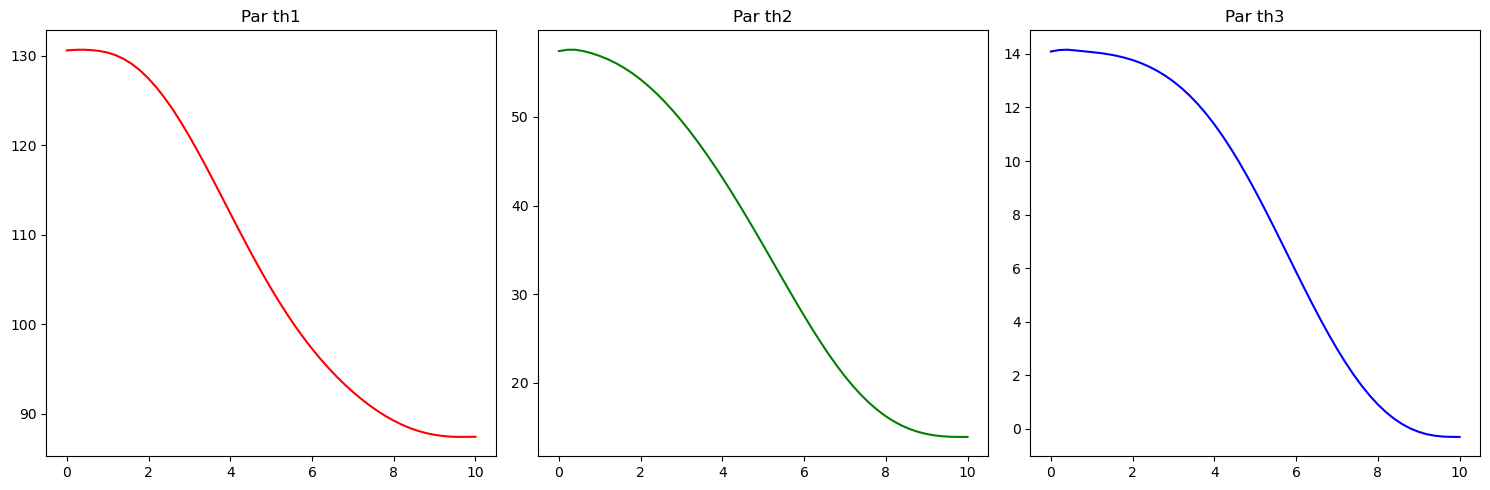

In [66]:
from sympy import solve, Symbol, Matrix, cos, sin, simplify, pi, diff, symbols
import matplotlib
import matplotlib.pyplot as plt
import numpy
%matplotlib inline
def polinomial_trayectory_generator(
                                      frec = 5, 
                                      time = (0, 10), 
                                      q_in = (0.1, 0.1, 0.1), 
                                      gdl_fn = (0.4, 0.4, 1.57)
                                   ):
    global gdl, gdl_dot, gdl_dot_dot, lam_s, lam_s_dot, lam_s_dot_dot, samples, gdl_in, ws, ws_dot, ws_dot_dot, om_1_C1, om_2_C2, om_3_C3, vel_1_C1, vel_2_C2, vel_3_C3
    a_0, a_1, a_2, a_3, a_4, a_5, t = symbols('a_0 a_1 a_2 a_3 a_4 a_5 t')
    lam = a_0 + a_1*t + a_2*(t**2) + a_3*(t**3) + a_4*(t**4) + a_5*(t**5)
    lam_dot = diff(lam, t)
    lam_dot_dot = diff(lam_dot, t)
    terms = solve([
      lam.subs(t, time[0]) - 0,
      lam.subs(t, time[1]) - 1,
      lam_dot.subs(t, time[0]) - 0,
      lam_dot.subs(t, time[1]) - 0,
      lam_dot_dot.subs(t, time[0]) - 0,
      lam_dot_dot.subs(t, time[1]) - 0
    ], [a_0, a_1, a_2, a_3, a_4, a_5], dict = True)
    #Lambda con valores sustituidos
    lam_s = lam.subs(terms[0])
    lam_s_dot = lam_dot.subs(terms[0])
    lam_s_dot_dot = lam_dot_dot.subs(terms[0])
    samples = frec * (time[1] - time[0]) + 1
    dt = 1.0 / frec
    #Posición inicial del efector final
    gdl_in = T_O_P[:3, 3].subs({theta_O_1: q_in[0],
                                theta_1_2: q_in[1],
                                theta_2_3: q_in[2]})
    #Creando arreglos para guardar las posiciones de los GDL
    gdl = []
    gdl_dot = []
    gdl_dot_dot = []
    for a in range(samples):
      gdl.append((gdl_in[0] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
                  gdl_in[1] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]), 
                  gdl_in[2] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2]) ))
      gdl_dot.append((lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
                      lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]), 
                      lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2]) ))
      gdl_dot_dot.append((lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
                      lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]), 
                      lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2]) ))
    #Obteniendo posición inicial del ws
    xi_desp = xi_O_P - Matrix([gdl_in[0], 
                               gdl_in[1], 
                               gdl_in[2]])
    #Calculando velocidad inicial
    xi_O_P_dot = Matrix([x_O_P_dot,
                         z_O_P_dot,
                         theta_O_P_dot])
    q_O_P_dot = J_inv * xi_O_P_dot #velocidad es jacobiano inverso por la velocidad inicial
    #Arreglos para guardar las posiciones del wsws = []
    ws = []
    ws_dot = []
    ws_dot_dot = []
    #Agregando posición inicial
    ws.append(q_in)
    #Agregando velocidad inicial
    q_dot_in = q_O_P_dot.subs({
      x_O_P_dot:     gdl_dot[0][0],
      z_O_P_dot:     gdl_dot[0][1],
      theta_O_P_dot: gdl_dot[0][2],
      theta_O_1: ws[0][0],
      theta_1_2: ws[0][1],
      theta_2_3: ws[0][2]})
    ws_dot.append(q_dot_in)
    #Calculando todos los valores por cinemática inversa
    for a in range(samples - 1):
      #Posición 
      ws.append((ws[a][0] + ws_dot[a][0] * dt,
                 ws[a][1] + ws_dot[a][1] * dt,
                 ws[a][2] + ws_dot[a][2] * dt))
      #Velocidad
      q_dot_iter = q_O_P_dot.subs({
                                      x_O_P_dot:gdl_dot[a+1][0],
                                      z_O_P_dot:gdl_dot[a+1][1],
                                      theta_O_P_dot: gdl_dot[a+1][2],
                                      theta_O_1: ws[a+1][0],
                                      theta_1_2: ws[a+1][1],
                                      theta_2_3: ws[a+1][2]})
      ws_dot.append(q_dot_iter)
      #Aceleración
      ws_dot_dot.append((
                    (ws_dot[a+1][0]-ws_dot[a][0]) / dt,
                    (ws_dot[a+1][1]-ws_dot[a][1]) / dt,
                    (ws_dot[a+1][2]-ws_dot[a][2]) / dt))
    #Aceleración final
    ws_dot_dot.append((0,0,0))
    gdl = gdl
    gdl_dot = gdl_dot
    gdl_dot_dot = gdl_dot_dot
    ws = ws
    ws_dot = ws_dot
    ws_dot_dot = ws_dot_dot
def effor_generator():
    frec = 5
    global tau_val, om_1_C1, om_2_C2, om_3_C3, vel_1_C1, vel_2_C2, vel_3_C3
    #Velocidades angulares de sistemas
    omega_1_1 = Matrix([0, 0, theta_O_1_dot])
    omega_2_2 = R_1_2.transpose() @ omega_1_1 + Matrix([0, 0, theta_1_2_dot])
    omega_3_3 = R_2_3.transpose() @ omega_2_2 + Matrix([0, 0, theta_2_3_dot]) 
    #Velocidades angulares de centros de masa
    omega_1_C1 = omega_1_1
    omega_2_C2 = omega_2_2
    omega_3_C3 = omega_3_3
    #Velocidades lineales de sistemas
    v_1_1 = Matrix([0, 0, 0])
    v_2_2 = R_1_2.transpose() * (omega_1_1.cross(p_1_2))
    v_3_3 = R_2_3.transpose() * (omega_2_2.cross(p_2_3))
    #Velocidades lineales de centros de masa
    v_1_C1 = v_1_1 + omega_1_1.cross(p_1_C1)
    v_2_C2 = v_2_2 + omega_2_2.cross(p_2_C2)
    v_3_C3 = v_3_3 + omega_3_3.cross(p_3_C3)
    #Arreglos para guardar velocidades angulares
    om_1_C1 = []
    om_2_C2 = []
    om_3_C3 = []
    #Arreglos para guardar velocidades lineales
    vel_1_C1 = []
    vel_2_C2 = []
    vel_3_C3 = []
    #Ciclo para todas las muestras
    for i in range(len(ws)):
      #Velocidades angulares
      om_1_C1.append(omega_1_C1.subs({
        theta_O_1_dot: ws_dot[i][0]
      }))
      om_2_C2.append(omega_2_C2.subs({
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1]
      }))
      om_3_C3.append(omega_3_C3.subs({
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1],
        theta_2_3_dot: ws_dot[i][2]
      }))
      #Velocidades lineales
      vel_1_C1.append(v_1_C1.subs({
        theta_O_1: ws[i][0],
        theta_O_1_dot: ws_dot[i][0]
      }))
      vel_2_C2.append(v_2_C2.subs({
        theta_O_1: ws[i][0],
        theta_1_2: ws[i][1],
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1]
      }))
      vel_3_C3.append(v_3_C3.subs({
        theta_O_1: ws[i][0],
        theta_1_2: ws[i][1],
        theta_2_3: ws[i][2],
        theta_O_1_dot: ws_dot[i][0],
        theta_1_2_dot: ws_dot[i][1],
        theta_2_3_dot: ws_dot[i][2]
      }))
    #Euler-Lagrange
    #Energía cinética
    k1 = 0.5 * m1 * v_1_C1.dot(v_1_C1) + 0.5 * omega_1_C1.dot(Ic1@omega_1_C1)
    k2 = 0.5 * m2 * v_2_C2.dot(v_2_C2) + 0.5 * omega_2_C2.dot(Ic2@omega_2_C2)
    k3 = 0.5 * m3 * v_3_C3.dot(v_3_C3) + 0.5 * omega_3_C3.dot(Ic3@omega_3_C3)
    k = k1 + k2 + k3
    #Energía potencial
    u1 = - m1 * Matrix([0, 0, g]).dot(p_0_C1)
    u2 = - m2 * Matrix([0, 0, g]).dot(p_0_C2)
    u3 = - m3 * Matrix([0, 0, g]).dot(p_0_C3)
    u = u1 + u2 + u3
    #Lagrangiano
    La = k - u
    #Derivadas respecto al espacio de trabajo
    La_dot_q = Matrix([diff(La, theta_O_1), 
                       diff(La, theta_1_2), 
                       diff(La, theta_2_3)])
    #Derivadas respecto a la derivada del espacio de trabajo
    La_dot_q_dot = Matrix([diff(La, theta_O_1_dot), 
                            diff(La, theta_1_2_dot), 
                            diff(La, theta_2_3_dot)])
    #Derivada total
    La_dot_q_dot_dt = diff(La_dot_q_dot, theta_O_1) * theta_O_1_dot + diff(La_dot_q_dot, theta_1_2) * theta_1_2_dot + diff(La_dot_q_dot, theta_2_3) * theta_2_3_dot + diff(La_dot_q_dot, theta_O_1_dot) * theta_O_1_dot_dot + diff(La_dot_q_dot, theta_1_2_dot) * theta_1_2_dot_dot + diff(La_dot_q_dot, theta_2_3_dot) * theta_2_3_dot_dot
    #Pares en las juntas
    tau = La_dot_q_dot_dt - La_dot_q
    #Generar valores numéricos
    tau_val = []
    #Ciclo para todas las muestras
    for i in range(len(ws)):
      tau_current = tau.subs({
          theta_O_1: ws[i][0],
          theta_1_2: ws[i][1],
          theta_2_3: ws[i][2],
          theta_O_1_dot: ws_dot[i][0],
          theta_1_2_dot: ws_dot[i][1],
          theta_2_3_dot: ws_dot[i][2],
          theta_O_1_dot_dot: ws_dot_dot[i][0],
          theta_1_2_dot_dot: ws_dot_dot[i][1],
          theta_2_3_dot_dot: ws_dot_dot[i][2],
          })
      tau_val.append(tau_current)
      tau_val = tau_val

# Función corregida para graficar esfuerzos
def effort_graphics():
    frec = 5
    global eff_t, eff_0, eff_1, eff_2
    # Grados de libertad
    eff_t = []
    eff_0 = []
    eff_1 = []
    eff_2 = []
    
    # Rellenar los datos a partir de tau_val
    for i in range(len(tau_val)):
        eff_t.append(float(i) / frec)
        eff_0.append(float(tau_val[i][0]))
        eff_1.append(float(tau_val[i][1]))
        eff_2.append(float(tau_val[i][2]))
    
    # Crear las figuras
    
    fig, (eff_plt_1, eff_plt_2, eff_plt_3) = plt.subplots(nrows = 1, ncols = 3, figsize=(15, 5))    
    #Gráficas GDL
    eff_plt_1.set_title("Par th1")
    eff_plt_1.plot(eff_t, eff_0, color = "RED")
    eff_plt_2.set_title("Par th2")
    eff_plt_2.plot(eff_t, eff_1, color = "GREEN")
    eff_plt_3.set_title("Par th3")
    eff_plt_3.plot(eff_t, eff_2, color = "BLUE")
    
    # Mostrar las gráficas
    plt.tight_layout()
    plt.show()
polinomial_trayectory_generator()
effor_generator()
effort_graphics()

### 8. Github
Para terminar, subir los archivos de la práctica al repositorio de github:
~~~ bash
repositorio_practicas/
├── practica_2
│   ├── imagenes
│   │   └── P2_IM1.png
│   └── Practica_2.ipynb
├── practica_3
│   ├── imagenes
│   │   └── P3_IM1.png
│   └── Practica_3.ipynb
└── README.md
~~~
**Dentro del archivo README.md (Creado de forma automática en el repositorio en línea), colocar los nombres de los integrantes del equipo.**

## Análisis de resultados

¿Qué utilidad tiene el modelo de dinámica inversa de un robot?
> El modelo de dinámica inversa es fundamental para entender y controlar el funcionamiento de un robot, ya que nos permite calcular los torques y fuerzas necesarios en sus juntas para realizar trayectorias específicas.

## Conclusiones

En esta práctica, logramos adentrarnos en los conceptos básicos relacionados con los formatos URDF, comprendimos su importancia para describir y simular estructuras robóticas de forma estándar. Además, aplicamos el modelo de dinámica inversa para analizar el comportamiento de un robot, trabajando específicamente con posiciones y velocidades de los centros de masa, matrices de inercia y el cálculo del Lagrangiano, lo que nos permitió profundizar en los fundamentos teóricos que sustentan el movimiento de robots manipuladores.  
El cálculo de los pares en las juntas y la representación gráfica de estos resultados nos permitió visualizar y entender cómo se distribuyen las fuerzas y momentos necesarios para generar movimiento. Este análisis es clave para evaluar y optimizar el desempeño del sistema.  

Finalmente, la configuración de un repositorio en línea para documentar y almacenar la práctica  reforzó nuestras habilidades en la gestión de proyectos y fomentó el uso de herramientas colaborativas que son esenciales. Integramos teoría, análisis y práctica, brindándonos un enfoque completo y aplicado.


## Bibliografía 
> F. J. Rubio Serrano y M. Abderrahim, Dinámica de Robots. Modelado y Control de Robots Manipuladores. España: Pearson Educación, 2009.

> J. Angeles, Fundamentos de Robótica: Análisis y Control de Manipuladores, 2ª ed. México: Alfaomega, 2007.

> R. Kelly, V. Santibáñez, y A. Loria, Control de Robots Manipuladores en el Espacio de las Articulaciones. México: Editorial Limusa, 2006.

> J. Stewart, Cálculo: Trascendentes Tempranas, 7ª ed. México: Cengage Learning, 2013.
